# Setup

In [1]:
from tensorflow import keras
import sklearn
from sklearn import metrics 
import pandas
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json
import random
from tabulate import tabulate

In [2]:
# maps encodings to possible genres
encoding_to_genre = {
    0: 'Country',
    1: 'Heavy Metal',
    2: 'Hip Hop',
    3: 'Indie',
    4: 'Pop',
    5: 'Rock',
}
genre_to_encoding = {g: e for e, g in encoding_to_genre.items()}

**Load sample**

In [3]:
# load sample of dataset 
df_sample = pandas.read_csv('dataset_sample.csv')

# load preprocessed tokens from this sample
all_tokens = []
with open('processed_tokens_sample.txt', 'r', encoding='utf-8') as infile:
    for line in infile:
        all_tokens.append(line)

**Load GloVe embeddings and generate vectors of embeddings based on the songs' tokens**

In [4]:
# load custom-trained GloVe embeddings for these songs
glove_vectors = []
with open('glove_vectors.txt', 'r', encoding='utf-8') as infile:
    for line in infile:
        vec = np.asarray(line.split(' ')[0:-1], dtype=float)
        glove_vectors.append(vec)
        
glove_dictionary = {}
with open('glove_dictionary.json', 'r') as jsonfile:
    glove_dictionary = json.load(jsonfile)

In [5]:
# generate features (vectors of GloVe embedding averages)

EMBEDDING_LENGTH = 200
embeddings = []

for doc_tokens in all_tokens:
    emb_avgs = []
    for token in doc_tokens.split(' '):
        # average glove embeddings vector for token
        # add this average to the document vector
        if token in glove_dictionary:
            emb_avgs.append(np.average(glove_vectors[glove_dictionary[token]]))
        else:
            emb_avgs.append(0)
    emb_avgs = np.array(emb_avgs)
    
    # pad with zeroes if not enough words in song
    if len(emb_avgs) < EMBEDDING_LENGTH:
        emb_avgs = np.pad(emb_avgs, (0, EMBEDDING_LENGTH - len(emb_avgs)), 'constant')
    # cut off extra tokens if too many words in song
    else:
        emb_avgs = emb_avgs[:EMBEDDING_LENGTH]
        
    embeddings.append(emb_avgs)

embeddings = np.array(embeddings, dtype=float)


**Helper Functions for Evaluation**

In [6]:
# counts prediction correct if predicted label is any one of the song's genres in the genre list
def lenient_accuracy(indices, predictions):
    correct = 0
    for test_index, df_index in enumerate(indices):
        for g in df_sample['Genres'].tolist()[df_index].split('; '):
            if g == encoding_to_genre[predictions[test_index]]:
                correct += 1
                break
    return correct / len(predictions)

# prints song data and predictions for a sample of n songs
def example_predictions(indices, actual, pred, count=50, lenient=False):
    print('Predictions')
    print('-----------')
    headers = ['Song Name', 'Artist', 'Predicted', 'Actual', 'Correct?']
    print_data = []
    for i in random.sample(range(0, len(indices)), count): # get n random points from test data
        df_index = indices[i]
        correct = 'Yes' if pred[i] == actual[i] else 'No'
        if lenient:
            correct = 'No'
            for g in df_sample['Genres'].tolist()[df_index].split('; '):
                if g == encoding_to_genre[pred[i]]:
                    correct = 'Yes'
                    break
        print_data.append([df_sample['SName'].tolist()[df_index], df_sample['Artist'].tolist()[df_index], 
                           encoding_to_genre[pred[i]], 
                            df_sample['Genres'].tolist()[df_index] if lenient else encoding_to_genre[df_sample['Top Genre'].tolist()[df_index]],
                           correct, 
                          ])
    print(tabulate(print_data, headers=headers))
    
# plots confusion matrix given predicted and true labels
def confusion_matrices(actual, pred):
    matrix = metrics.confusion_matrix(actual, pred)
    labels = ['Country', 'Heavy Metal', 'Hip Hop', 'Indie', 'Pop', 'Rock']
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = labels)

    fig, ax = plt.subplots(figsize=(12,10))
    cm_display.plot(ax=ax)
    plt.show()

**Load pre-trained models**
to skip training time

In [7]:
# Logistic Regression
lr = None
with open('lr_model.pkl', 'rb') as infile:
    lr = pickle.load(infile)

# LSTM
lstm = keras.models.load_model('lstm_model')

# Predictions

In [8]:
# declare the features and labels
X = embeddings
y = df_sample['Top Genre']
indices = np.arange(len(X))

**Logistic Regression Model**

In [9]:
y_pred_lr = lr.predict(X)
print("Logistic Regression Accuracy %.3f" % sklearn.metrics.accuracy_score(y, y_pred_lr))
print("for multiple genres: %.3f" % lenient_accuracy(indices, y_pred_lr))

Logistic Regression Accuracy 0.469
for multiple genres: 0.528


In [10]:
example_predictions(indices, y, y_pred_lr, lenient=False)

Predictions
-----------
Song Name                              Artist                    Predicted    Actual       Correct?
-------------------------------------  ------------------------  -----------  -----------  ----------
My Wave                                Soundgarden               Pop          Rock         No
Gum                                    Cupcakke                  Hip Hop      Hip Hop      Yes
Happy New Year                         Never Shout Never         Pop          Indie        No
Unnamed Feeling                        Metallica                 Pop          Rock         No
Take a Risk                            Chris Brown               Hip Hop      Hip Hop      Yes
Sugar Ray                              The Jesus and Mary Chain  Rock         Rock         Yes
Trying to Get to You                   Faith Hill                Rock         Country      No
Hi, Hi, Hi,                            Paul McCartney            Rock         Rock         Yes
Great Heathen Army

**LSTM Model**

In [11]:
y_pred_lstm = lstm.predict(X, batch_size=120)
y_pred_lstm = y_pred_lstm.argmax(axis=1)
print("LSTM RNN Accuracy %.3f" % metrics.accuracy_score(y, y_pred_lstm))
print("for multiple genres: %.3f" % lenient_accuracy(indices, y_pred_lstm))


4/4 [==============================] - 5s 389ms/step
LSTM RNN Accuracy 0.478
for multiple genres: 0.539


In [12]:
example_predictions(indices, y, y_pred_lstm, lenient=False)

Predictions
-----------
Song Name                     Artist                    Predicted    Actual       Correct?
----------------------------  ------------------------  -----------  -----------  ----------
Minus Human                   Metallica                 Rock         Rock         Yes
I Can do It Without You       Kaiser Chiefs             Rock         Indie        No
Prophecies                    Blind Guardian            Hip Hop      Heavy Metal  No
Illuminati                    Korn                      Rock         Heavy Metal  No
Misty Blue                    Korn                      Rock         Heavy Metal  No
Poison                        Motörhead                 Rock         Heavy Metal  No
New Romantics                 Taylor Swift              Hip Hop      Pop          No
The Beauty Within You         Ariana Grande             Rock         Pop          No
Life Rolls On                 Florida Georgia Line      Pop          Country      No
Refusal Of Penance        

**Confusion Matrices**

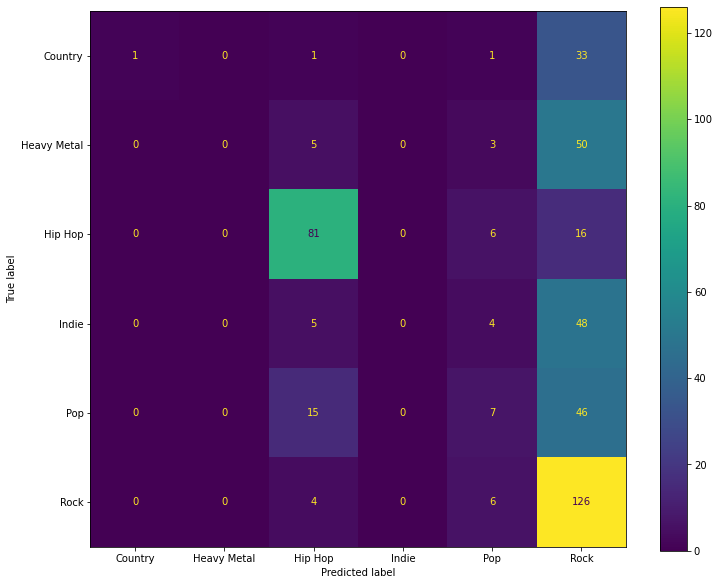

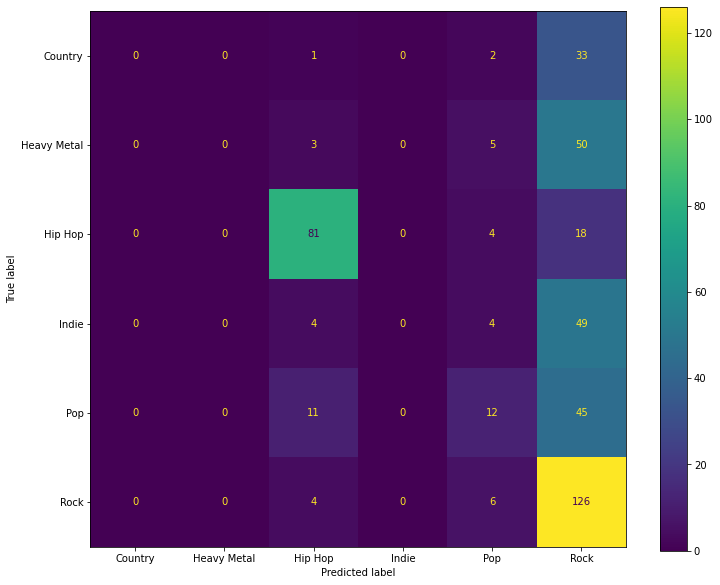

In [13]:
confusion_matrices(y.tolist(), y_pred_lr)
confusion_matrices(y.tolist(), y_pred_lstm)